**Etudiants :**<br/>
3701123 - Pascal ZHUANG<br/>
3680881 - Richard UNG

# **DM 2**

**Données Kaggle :** [USA Housing Listings](https://www.kaggle.com/austinreese/usa-housing-listings)

## **Préparation**

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/DM2/"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


['housing.csv']

**Installer pyspark et findspark :**

In [ ]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 46.9 MB/s 


**Démarrer la session spark :**

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1636642079079


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))


Nombre de partitions utilisées :  8


## **Chargement des données**

Nous observons que les données ne sont pas correctement chargées lorsque nous chargeons directement avec la librairie *Pyspark*.<br/>
Nous avons donc commencé par lire le fichier *csv* avec la librairie *Pandas* puis nous le convertissons ensuite en dataframe *Pyspark*.<br/><br/>


**Lecture du fichier à partir de la librarie *Pandas* :**

In [ ]:
import pandas as pd

housing_df = pd.read_csv(drive_dir +"housing.csv")
print("Dimensions :", housing_df.shape, "\n")

Dimensions : (384977, 22) 



**Conversion du dataframe Pandas en dataframe Pyspark :**

In [ ]:
schema = StructType() \
      .add("id",LongType(), True) \
      .add("url",StringType(), True) \
      .add("region",StringType(), True) \
      .add("region_url",StringType(), True) \
      .add("price",LongType(), True) \
      .add("type",StringType(), True) \
      .add("sqfeet",IntegerType(), True) \
      .add("beds",IntegerType(), True) \
      .add("baths",DoubleType(), True) \
      .add("cats_allowed",IntegerType(), True) \
      .add("dogs_allowed",IntegerType(), True) \
      .add("smoking_allowed",IntegerType(), True) \
      .add("wheelchair_access",IntegerType(), True) \
      .add("electric_vehicle_charge",IntegerType(), True) \
      .add("comes_furnished",IntegerType(), True) \
      .add("laundry_options",StringType(), True) \
      .add("parking_options",StringType(), True) \
      .add("image_url",StringType(), True) \
      .add("description",StringType(), True) \
      .add("lat",DoubleType(), True) \
      .add("long",DoubleType(), True) \
      .add("state",StringType(), True)

df = spark.createDataFrame(housing_df, schema=schema)

df.show(10)
df.printSchema()

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|               long|state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|7049044568|https://reno.crai...|reno / tahoe|https://reno.cr

**Création de listes contenant les noms de colonnes selon son type :**

In [ ]:
# Liste des colonnes numériques
num_col = ["price", "sqfeet", "beds", "baths", "lat", "long"]

# Liste des colonnes catégorielles encodées
cat_col = ["cats_allowed", "dogs_allowed", "smoking_allowed",\
           "electric_vehicle_charge", "comes_furnished", "wheelchair_access"]

# Liste des colonnes catégorielles non encodées (type : string)
str_col = ["url", "region", "region_url", "type", "laundry_options",\
           "parking_options", "image_url", "description", "state"]

## **Exploration des données**
**Statistiques rapides sur les variables numériques :**

In [ ]:
df.select(num_col).describe().show()

+-------+-----------------+------------------+------------------+------------------+--------+--------+
|summary|            price|            sqfeet|              beds|             baths|     lat|    long|
+-------+-----------------+------------------+------------------+------------------+--------+--------+
|  count|           384977|            384977|            384977|            384977|  384977|  384977|
|   mean|8825.722318476168| 1059.899565428584|1.9053449946360432|1.4807183286274246|     NaN|     NaN|
| stddev|4462199.876538977|19150.757244214365|3.4945716198252246|0.6180605193011355|     NaN|     NaN|
|    min|                0|                 0|                 0|               0.0|-43.5333|-163.894|
|    max|       2768307249|           8388607|              1100|              75.0|     NaN|     NaN|
+-------+-----------------+------------------+------------------+------------------+--------+--------+



* Les colonnes *price* et *sqfeet* possèdent des valeurs très grandes par rapport aux autres colonnes, il faudra donc **normaliser nos données** avant de les passer à notre modèle de prédiction pour avoir la **même échelle** dans les différentes colonnes. <br/>
Par ailleurs, lorsque l'on a trop de valeurs distinctes dans une catégorie, l'arbre de régression n'arrive pas à le supporter.<br/><br/>

* Les colonnes donnant la *latitude (lat)* et la *longitude (long)* possèdent toutes les deux des valeurs manquantes, nous pouvons donc : 
  * soit **supprimer les lignes concernées** 
  * soit les **compléter** avec une valeur (mean, median, mode, ...)<br/>

Par la suite, nous choisirons de **supprimer ces lignes**.

**Valeurs distinctes sur les variables catégorielles :**

In [ ]:
df.select([countDistinct(c).alias(c) for c in str_col+cat_col]).show()

+------+------+----------+----+---------------+---------------+---------+-----------+-----+------------+------------+---------------+-----------------------+---------------+-----------------+
|   url|region|region_url|type|laundry_options|parking_options|image_url|description|state|cats_allowed|dogs_allowed|smoking_allowed|electric_vehicle_charge|comes_furnished|wheelchair_access|
+------+------+----------+----+---------------+---------------+---------+-----------+-----+------------+------------+---------------+-----------------------+---------------+-----------------+
|384977|   404|       413|  12|              6|              8|   181068|     280837|   51|           2|           2|              2|                      2|              2|                2|
+------+------+----------+----+---------------+---------------+---------+-----------+-----+------------+------------+---------------+-----------------------+---------------+-----------------+



Nous supposons que certaines de ces variables **ne sont pas pertinentes** pour la prédiction de *price*:
* Les colonnes *id* et *url* ne nous apportent aucun renseignement supplémentaire pouvant influencer le prix .
* La colonne *region_url* dont l'information pertinente se trouve dans la colonne *region*.
* La colonne *description* qui contient un texte plus ou moins long, difficile à extraire les informations pertinentes sans faire du NLP.

Nous pourrons donc considérer la **suppression** de ces colonnes du dataframe avant de le passer au modèle de régression.

**Valeurs manquantes :**

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+----+----+-----+
| id|url|region|region_url|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|image_url|description| lat|long|state|
+---+---+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+----+----+-----+
|  0|  0|     0|         0|    0|   0|     0|   0|    0|           0|           0|              0|                0|                      0|              0|          79026|         140687|        0|          2|1918|1918|    0|
+---+---+------+----------+-----+----+------+----+-----+------------+------------+----------

**Valeurs manquantes en pourcentage tronquées à 2 chiffres après la virgule :**

In [ ]:
df.select([format_number(count(when(isnan(c), c))*100/count('id'),2).alias(c) for c in df.columns]).show()

+----+----+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+----+----+-----+
|  id| url|region|region_url|price|type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|parking_options|image_url|description| lat|long|state|
+----+----+------+----------+-----+----+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+---------------+---------+-----------+----+----+-----+
|0.00|0.00|  0.00|      0.00| 0.00|0.00|  0.00|0.00| 0.00|        0.00|        0.00|           0.00|             0.00|                   0.00|           0.00|          20.53|          36.54|     0.00|       0.00|0.50|0.50| 0.00|
+----+----+------+----------+-----+----+------+----+-----+------------+------------+

Nous observons **cinq colonnes ayant des valeurs manquantes** dont les colonnes *description*, *lat* et *long* que nous avons déjà vu prédemment.<br/>

Les deux autres colonnes qui possèdent des valeurs manquantes sont *laundry_options* et *parking_options* qui en possèdent un nombre **assez conséquent** (respectivement 20.53% et 36.54%). 

Comme pour les colonnes de la latitude et de la longitude, nous pouvons :
1. soit **supprimer les lignes où il y a une valeur manquante**, les valeurs manquantes étant assez nombreuses, nous pouvons perdre des exemples pertinents.
2. soit directement **supprimer les colonnes**, mais cela ne semble pas un bon choix, la présence d'un parking ou d'une laverie devrait faire varier le prix d'un appartement et est donc potentiellement pertinente pour la prédiction.
3. soit leur **assigner des valeurs**, mais ajouter des valeurs pré-définies peut introduire des biais.<br/>

Nous allons par la suite choisir la **3ème méthode**.

## **Préparation des données**

### **Stratégie**

**Suppression des colonnes non pertinentes :**

In [ ]:
# Liste des colonnes numériques
num_col = ["sqfeet", "beds", "baths", "lat", "long"]

# Liste des colonnes catégorielles encodées
cat_col = ["cats_allowed", "dogs_allowed", "smoking_allowed",\
           "electric_vehicle_charge", "comes_furnished", "wheelchair_access"]

# Liste des colonnes catégorielles non encodées (type : string)
str_col = ["region", "type", "laundry_options", "parking_options", "state"]

df_prep = df.select(["price"]+num_col+cat_col+str_col)
df_prep.show(5)

+-----+------+----+-----+-------+--------+------------+------------+---------------+-----------------------+---------------+-----------------+------------+---------+---------------+---------------+-----+
|price|sqfeet|beds|baths|    lat|    long|cats_allowed|dogs_allowed|smoking_allowed|electric_vehicle_charge|comes_furnished|wheelchair_access|      region|     type|laundry_options|parking_options|state|
+-----+------+----+-----+-------+--------+------------+------------+---------------+-----------------------+---------------+-----------------+------------+---------+---------------+---------------+-----+
| 1148|  1078|   3|  2.0|39.5483|-119.796|           1|           1|              0|                      0|              0|                0|reno / tahoe|apartment|    w/d in unit|        carport|   ca|
| 1200|  1001|   2|  2.0|39.5026|-119.789|           0|           0|              0|                      0|              0|                0|reno / tahoe|    condo|    w/d hookups|   

**Pipeline des colonnes numériques :**

In [ ]:
from pyspark.ml.feature import RobustScaler, VectorAssembler
from pyspark.ml import Pipeline

# Suppression des 1918 lignes contenant une valeur manquante pour les colonnes lat et long
df_prep = df_prep.where(~(isnan("lat") | isnan("long")))

# Concaténation des colonnes numériques
vec_assembler = VectorAssembler(inputCols=num_col, outputCol='num_features')

# Normalisation avec RobustScaler car présence probable de valeurs aberrantes
scaler = RobustScaler(inputCol = 'num_features', outputCol='scaled_num_features')

# Pipeline des colonnes numériques
num_stages = [vec_assembler, scaler]
num_pipeline = Pipeline(stages = num_stages)
df_prep = num_pipeline.fit(df_prep).transform(df_prep)

# Affichages des colonnes concernées
df_prep.select(num_col+['num_features', 'scaled_num_features']).show(10, truncate=False)

+------+----+-----+-------+-------------------+--------------------------------------------+-------------------------------------------------------------------+
|sqfeet|beds|baths|lat    |long               |num_features                                |scaled_num_features                                                |
+------+----+-----+-------+-------------------+--------------------------------------------+-------------------------------------------------------------------+
|1078  |3   |2.0  |39.5483|-119.796           |[1078.0,3.0,2.0,39.5483,-119.796]           |[2.7017543859649122,3.0,2.0,5.147373490212411,-6.11157309389588]   |
|1001  |2   |2.0  |39.5026|-119.789           |[1001.0,2.0,2.0,39.5026,-119.789]           |[2.508771929824561,2.0,2.0,5.1414254477301125,-6.111215978369007]  |
|1683  |2   |2.0  |39.6269|-119.708           |[1683.0,2.0,2.0,39.6269,-119.708]           |[4.2180451127819545,2.0,2.0,5.1576036026655565,-6.107083641558048] |
|708   |1   |1.0  |39.4477|-119.77

**Pipeline des colonnes catégorielles :**

In [ ]:
from pyspark.ml.feature import StringIndexer

# Indexation des chaines de caractères
index_names = ['indexed_'+s for s in str_col]
indexer = StringIndexer(inputCols=str_col, outputCols=index_names)

# Concaténation des colonnes catégorielles
vec_assembler = VectorAssembler(inputCols=cat_col+index_names, outputCol='cat_features')

# Pipeline des colonnes catégorielles
cat_stages = [indexer, vec_assembler]
cat_pipeline = Pipeline(stages = cat_stages)
df_prep = cat_pipeline.fit(df_prep).transform(df_prep)

# Affichages des colonnes concernées
df_prep.select(str_col+index_names+['cat_features']).show(15, truncate=False)

+------------+---------+---------------+------------------+-----+--------------+------------+-----------------------+-----------------------+-------------+----------------------------------------------+
|region      |type     |laundry_options|parking_options   |state|indexed_region|indexed_type|indexed_laundry_options|indexed_parking_options|indexed_state|cat_features                                  |
+------------+---------+---------------+------------------+-----+--------------+------------+-----------------------+-----------------------+-------------+----------------------------------------------+
|reno / tahoe|apartment|w/d in unit    |carport           |ca   |20.0          |0.0         |0.0                    |3.0                    |0.0          |(11,[0,1,6,9],[1.0,1.0,20.0,3.0])             |
|reno / tahoe|condo    |w/d hookups    |carport           |ca   |20.0          |3.0         |2.0                    |3.0                    |0.0          |(11,[6,7,8,9],[20.0,3.0,2.0,3.0])

L'indexer semble mettre toutes les valeurs manquantes dans une même catégorie, les valeurs NaN sont alors éliminées.

**Affichages des features produites :**

In [ ]:
df_prep.select("scaled_num_features", "cat_features").show(10, truncate=False)

+-------------------------------------------------------------------+----------------------------------------------+
|scaled_num_features                                                |cat_features                                  |
+-------------------------------------------------------------------+----------------------------------------------+
|[2.7017543859649122,3.0,2.0,5.147373490212411,-6.11157309389588]   |(11,[0,1,6,9],[1.0,1.0,20.0,3.0])             |
|[2.508771929824561,2.0,2.0,5.1414254477301125,-6.111215978369007]  |(11,[6,7,8,9],[20.0,3.0,2.0,3.0])             |
|[4.2180451127819545,2.0,2.0,5.1576036026655565,-6.107083641558048] |(11,[0,1,2,6,9],[1.0,1.0,1.0,20.0,2.0])       |
|[1.7744360902255638,1.0,1.0,5.134279987505206,-6.110297681299905]  |(11,[0,1,2,6,9],[1.0,1.0,1.0,20.0,3.0])       |
|[0.6265664160401002,0.0,1.0,5.1457335485214495,-6.1120322424304305]|[1.0,1.0,1.0,0.0,1.0,1.0,20.0,0.0,3.0,0.0,0.0]|
|[1.8045112781954886,1.0,1.0,5.1355164514785505,-6.1105527638191

**Assemblage des features :**

In [ ]:
features_col = ["scaled_num_features", "cat_features"]
vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
df_prep = vec_assembler.transform(df_prep)

df_prep.select('features').show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|features                                                                                                        |
+----------------------------------------------------------------------------------------------------------------+
|(16,[0,1,2,3,4,5,6,11,14],[2.7017543859649122,3.0,2.0,5.147373490212411,-6.11157309389588,1.0,1.0,20.0,3.0])    |
|(16,[0,1,2,3,4,11,12,13,14],[2.508771929824561,2.0,2.0,5.1414254477301125,-6.111215978369007,20.0,3.0,2.0,3.0]) |
|[4.2180451127819545,2.0,2.0,5.1576036026655565,-6.107083641558048,1.0,1.0,1.0,0.0,0.0,0.0,20.0,0.0,0.0,2.0,0.0] |
|[1.7744360902255638,1.0,1.0,5.134279987505206,-6.110297681299905,1.0,1.0,1.0,0.0,0.0,0.0,20.0,0.0,0.0,3.0,0.0]  |
|[0.6265664160401002,0.0,1.0,5.1457335485214495,-6.1120322424304305,1.0,1.0,1.0,0.0,1.0,1.0,20.0,0.0,3.0,0.0,0.0]|
|[1.8045112781954886,1.0,1.0,5.1355164514785505,-6.110552763819101,1.0,1.0,1.0,0

**Suppression des étiquettes aberrantes :**

![](https://editor.analyticsvidhya.com/uploads/12311IQR.png)


Tout d'abord nous nous sommes appuyé sur l'utilisation des **quartiles** afin d'essayer de **retirer les outliers**.

q1, q3, iqr, lower, upper nous donne respectivement 806.0, 1395.0, 589.0, -77.5 et 2278.5.

Comme on peut le voir **lower est négatif**, de ce fait il est inutilisable pour *price* qui ne peut être inférieur à 0. De façon empirique, nous avons trouvé une tranche de valeur permettant d'avoir suffisamment de valeurs exploitables tout en retirant les outliers.

In [ ]:
q1, q3 = df_prep.approxQuantile('price', [0.25, 0.75], 0)
iqr = q3 - q1
lower = q1 - (iqr * 1.5)
upper = q3 + (iqr * 1.5)

print(q1, q3, iqr, lower, upper)

# Suppression d'ouliers
df_prep = df_prep.where((col('price') > 450) & ((col('price') < 3000)))

# Affichage des features et du label
df_prep.select('features', col('price').alias('label')).show(truncate=False)

806.0 1395.0 589.0 -77.5 2278.5
+---------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                       |label|
+---------------------------------------------------------------------------------------------------------------+-----+
|(16,[0,1,2,3,4,5,6,11,14],[2.7017543859649122,3.0,2.0,5.147373490212411,-6.11157309389588,1.0,1.0,20.0,3.0])   |1148 |
|(16,[0,1,2,3,4,11,12,13,14],[2.508771929824561,2.0,2.0,5.1414254477301125,-6.111215978369007,20.0,3.0,2.0,3.0])|1200 |
|[4.2180451127819545,2.0,2.0,5.1576036026655565,-6.107083641558048,1.0,1.0,1.0,0.0,0.0,0.0,20.0,0.0,0.0,2.0,0.0]|1813 |
|[1.7744360902255638,1.0,1.0,5.134279987505206,-6.110297681299905,1.0,1.0,1.0,0.0,0.0,0.0,20.0,0.0,0.0,3.0,0.0] |1095 |
|[1.8045112781954886,1.0,1.0,5.1355164514785505,-6.110552763819101,1.0,1.0,1.0,0.0,0.0,0.0,20.0,0.0,4.0,0.0,0.0]|1093 |
|[1.6566

### **Sans stratégie**

**Traitement des colonnes numériques :**

Pour la version sans stratégie nous avons quand même **supprimer les lignes avec valeurs manquantes** des colonnes *lat* et *long* afin d'avoir le même nombre de ligne que les données avec stratégie. Ainsi, le découpage **train/test** se fera de la même façon avec un *seed* équivalent.

In [ ]:
from pyspark.ml.feature import RobustScaler, VectorAssembler
from pyspark.ml import Pipeline

# Suppression des 1918 lignes contenant une valeur manquante pour les colonnes lat et long
df_no_prep = df.where(~(isnan("lat") | isnan("long")))

# Concaténation des colonnes numériques
vec_assembler = VectorAssembler(inputCols=num_col[1:], outputCol='num_features')
df_no_prep = vec_assembler.transform(df_no_prep)

# Affichages des colonnes concernées
df_no_prep.select(num_col+['num_features']).show(10, truncate=False)

+-----+------+----+-----+-------+-------------------+--------------------------------------------+
|price|sqfeet|beds|baths|lat    |long               |num_features                                |
+-----+------+----+-----+-------+-------------------+--------------------------------------------+
|1148 |1078  |3   |2.0  |39.5483|-119.796           |[1078.0,3.0,2.0,39.5483,-119.796]           |
|1200 |1001  |2   |2.0  |39.5026|-119.789           |[1001.0,2.0,2.0,39.5026,-119.789]           |
|1813 |1683  |2   |2.0  |39.6269|-119.708           |[1683.0,2.0,2.0,39.6269,-119.708]           |
|1095 |708   |1   |1.0  |39.4477|-119.771           |[708.0,1.0,1.0,39.4477,-119.771]            |
|289  |250   |0   |1.0  |39.5357|-119.805           |[250.0,0.0,1.0,39.5357,-119.805]            |
|1093 |720   |1   |1.0  |39.4572|-119.77600000000001|[720.0,1.0,1.0,39.4572,-119.77600000000001] |
|935  |661   |1   |1.0  |39.5118|-119.802           |[661.0,1.0,1.0,39.5118,-119.802]            |
|1095 |708

**Pipeline des colonnes catégorielles :**

Nous avons supprimé les colonnes *description* et *url* car elles contiennent **trop de valeurs distinctes**. L'arbre de regression ne supporte pas autant d'éléments. Nous aurions pu utiliser la fonction Bucketizer afin de **réduire le nombres de valeurs distinctes** mais cela ne change pas le fait que *description* ne changera pas le prix et que les informations de *url* sont dans *region_url*.

In [ ]:
from pyspark.ml.feature import StringIndexer

str_col = [ "region", "region_url", "type", "laundry_options",\
           "parking_options", "image_url", "state"]

# Indexation des chaines de caractères
index_names = ['indexed_'+s for s in str_col]
indexer = StringIndexer(inputCols=str_col, outputCols=index_names)

In [ ]:
# Concaténation des colonnes catégorielles
vec_assembler = VectorAssembler(inputCols=cat_col+ index_names, outputCol='cat_features')

cat_stages = [indexer, vec_assembler]
cat_pipeline = Pipeline(stages = cat_stages)
df_no_prep = cat_pipeline.fit(df_no_prep).transform(df_no_prep)

**Assemblage des features**

In [ ]:
features_col = ["num_features", "cat_features"]
vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
df_no_prep = vec_assembler.transform(df_no_prep)

df_no_prep.select('features').show(10, truncate=False)

+------------------------------------------------------------------------------------------------------+
|features                                                                                              |
+------------------------------------------------------------------------------------------------------+
|[1078.0,3.0,2.0,39.5483,-119.796,1.0,1.0,0.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,3.0,1080.0,0.0]            |
|[1001.0,2.0,2.0,39.5026,-119.789,0.0,0.0,0.0,0.0,0.0,0.0,20.0,16.0,3.0,2.0,3.0,41232.0,0.0]           |
|[1683.0,2.0,2.0,39.6269,-119.708,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,2.0,19113.0,0.0]           |
|[708.0,1.0,1.0,39.4477,-119.771,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,3.0,498.0,0.0]              |
|[250.0,0.0,1.0,39.5357,-119.805,1.0,1.0,1.0,0.0,1.0,1.0,20.0,16.0,0.0,3.0,0.0,110.0,0.0]              |
|[720.0,1.0,1.0,39.4572,-119.77600000000001,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,4.0,0.0,11592.0,0.0] |
|[661.0,1.0,1.0,39.5118,-119.802,1.0,1.0,1.0,0.0,0.0,0.

In [ ]:
# Suppression d'ouliers
df_no_prep = df_no_prep.where((col('price') > 450) & ((col('price') < 3000)))

# Affichage des features et du label
df_no_prep.select('features', col('price').alias('label')).show(truncate=False)

+------------------------------------------------------------------------------------------------------+-----+
|features                                                                                              |label|
+------------------------------------------------------------------------------------------------------+-----+
|[1078.0,3.0,2.0,39.5483,-119.796,1.0,1.0,0.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,3.0,1080.0,0.0]            |1148 |
|[1001.0,2.0,2.0,39.5026,-119.789,0.0,0.0,0.0,0.0,0.0,0.0,20.0,16.0,3.0,2.0,3.0,41232.0,0.0]           |1200 |
|[1683.0,2.0,2.0,39.6269,-119.708,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,2.0,19113.0,0.0]           |1813 |
|[708.0,1.0,1.0,39.4477,-119.771,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,0.0,3.0,498.0,0.0]              |1095 |
|[720.0,1.0,1.0,39.4572,-119.77600000000001,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,4.0,0.0,11592.0,0.0] |1093 |
|[661.0,1.0,1.0,39.5118,-119.802,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.0,0.0,3.0,1.0,77411.0,0.0]            |935  |
|

## **Modeling**

**Modèle avec stratégie :**

* Nous séparons dans un premier temps les données afin d'obtenir un **ensemble d'apprentissage** qui servira à entraîner notre modèle et un **ensemble de test** utilisé pour l'évaluation des performances du modèle.
* Le paramètre *maxBins* de l'arbre de décision doit **être supérieur ou égal** au nombre de valeurs distinctes de la colonne en possèdant le plus.
* Le **GridSearch** met environ 5 minutes à s'exécuter.

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Création des valeurs d'entrainement (80%) et de test (20%)
train_data, test_data = df_prep.select('features', col('price').alias('label')).randomSplit([0.8, 0.2], seed=0)

# maxBins doit être supérieur ou égal au nombre de valeurs distinctes de la colonne en possèdant le plus.
# La colonne région contient 404 valeurs distinctes
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxBins=404)

# Paramètres à explorer par le GridSearch
dt_paramGrid = ParamGridBuilder()\
        .addGrid(dt.minInstancesPerNode, [10, 100])\
        .build()

# Evaluateur
evaluatorPR = RegressionEvaluator()

# Cross validation avec 3 folds
cv = CrossValidator(estimator=dt,\
                    estimatorParamMaps=dt_paramGrid,\
                    evaluator = evaluatorPR,\
                    numFolds=3,\
                    parallelism=2)

# Recherche des meilleurs hyperparamètres
cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel

# Affichage
# print(bestModel.toDebugString)

**Résultats sur les données de test avec stratégie :**

RMSE : 279.96711900884804
MAE  : 195.43206159439336


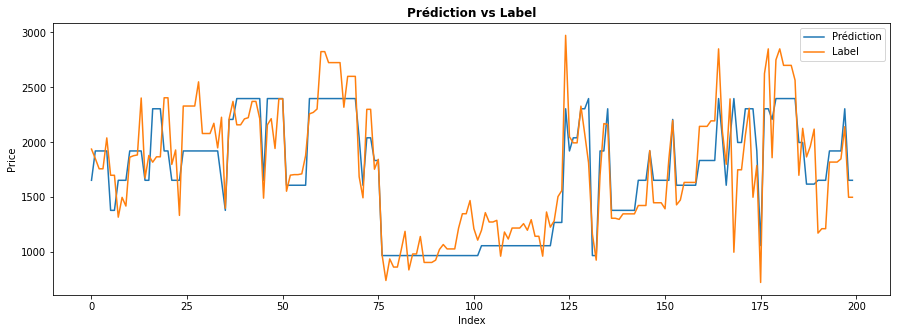

In [ ]:
import matplotlib.pyplot as plt

# Prédictions sur les données de tests
pred_df = bestModel.transform(test_data)

# Evaluation avec les métriques RMSE et MAE
eval_rmse = RegressionEvaluator(metricName='rmse')
print('RMSE :', eval_rmse.evaluate(pred_df))
eval_mae = RegressionEvaluator(metricName='mae')
print('MAE  :', eval_mae.evaluate(pred_df))

# Récupération des valeurs pour les plots
yhat = pred_df.select("prediction").collect()
y_true = test_data.select("label").collect()

# Plots
nb_points = 200
plt.figure(figsize=(15,5))
plt.title("Prédiction vs Label", fontweight='bold')
plt.xlabel("Index")
plt.ylabel('Price')
plt.plot(range(0, nb_points), yhat[:nb_points], label='Prédiction')
plt.plot(range(0, nb_points), y_true[:nb_points], label='Label')
plt.legend()
plt.show()

Nous observons que la ligne bleue suit plus ou moins bien celle en orange. Le modèle semble assez performant.<br/>
La RMSE étant sur la même unité que l'étiquette, nous pouvons alors dire que le modèle se trompe en moyenne de 280 sur le prix.

**Modèle sans stratégie**

* Nous séparons dans un premier temps les données afin d'obtenir un **ensemble d'apprentissage** qui servira à entraîner notre modèle et un **ensemble de test** utilisé pour l'évaluation des performances du modèle.
* Le paramètre *maxBins* de l'arbre de décision doit **être supérieur ou égal** au nombre de valeurs distinctes de la colonne en possèdant le plus.
* **L'exécution du GridSearch prend 4 heures à 12 heures.**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Création des valeurs d'entrainement (80%) et de test (20%)
train_data, test_data = df_no_prep.select('features', col('price').alias('label')).randomSplit([0.8, 0.2], seed=0)

# maxBins doit au moins être supérieur ou égal à la colonne possédant la plus grande valeur de nombres distincts
# La colonne région contient 180157 valeurs distinctes
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxBins=180157)

# Paramètres à explorer par le GridSearch
dt_paramGrid = ParamGridBuilder()\
        .addGrid(dt.minInstancesPerNode, [10, 100])\
        .build()

# Evaluateur
evaluatorPR = RegressionEvaluator()

# Cross validation avec 3 folds
cv = CrossValidator(estimator=dt,\
                    estimatorParamMaps=dt_paramGrid,\
                    evaluator = evaluatorPR,\
                    numFolds=3,\
                    parallelism=2)

# Recherche des meilleurs hyperparamètres
cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel

# Affichage
# print(bestModel.toDebugString)

**Résultats sur les données de test sans stratégie :**

RMSE : 1048.9480400078503
MAE  : 645.0423931837042


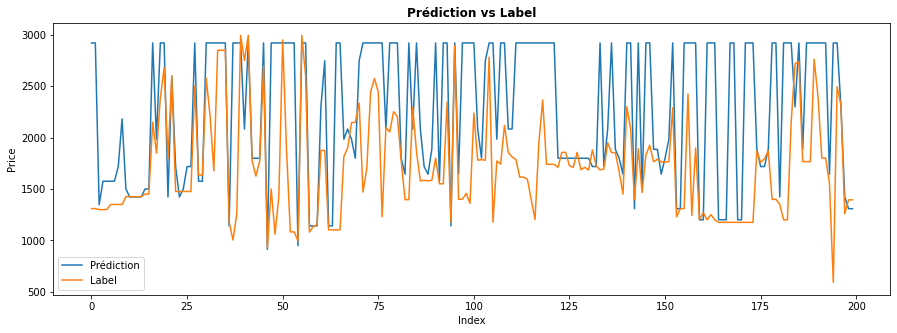

In [ ]:
import matplotlib.pyplot as plt

# Prédictions sur les données de tests
pred_df = bestModel.transform(test_data)

# Evaluation avec les métriques RMSE et MAE
eval_rmse = RegressionEvaluator(metricName='rmse')
print('RMSE :', eval_rmse.evaluate(pred_df))
eval_mae = RegressionEvaluator(metricName='mae')
print('MAE  :', eval_mae.evaluate(pred_df))

# Récupération des valeurs pour les plots
yhat = pred_df.select("prediction").collect()
y_true = test_data.select("label").collect()

# Plots
nb_points = 200
plt.figure(figsize=(15,5))
plt.title("Prédiction vs Label", fontweight='bold')
plt.xlabel("Index")
plt.ylabel('Price')
plt.plot(range(0, nb_points), yhat[:nb_points], label='Prédiction')
plt.plot(range(0, nb_points), y_true[:nb_points], label='Label')
plt.legend()
plt.show()

Nous pouvons constater que le modèle avec les données "sans stratégie" possède **une RMSE et une MAE beaucoup plus haute** par rapport au modèle qui précède (celle avec stratégie) et une courbe bleue qui suit beaucoup moins bien celle en orange.<br/>
Le pre-processing des données a permis au premier modèle d'être beaucoup plus performant que le second.<br/>

**La préparation des données joue donc un rôle capital dans le Machine Learning.**